In [1]:
import pandas as pd
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [2]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [3]:
def all_func(df):
    df1 = process_missing(df)
    df1 = process_age(df1)
    df1 = process_fare(df1)
    df1 = process_titles(df1)
    df1 = process_cabin(df1)
    for i in ["Age_categories", "Fare_categories", "Title", "Cabin_type", "Sex"]:
        df1 = create_dummies(df1, i)
    return df1
train = all_func(train)
holdout = all_func(holdout)

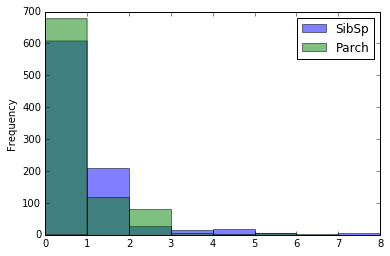

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
cols = ["SibSp", "Parch", "Survived"]
train[cols].drop("Survived",axis=1).plot.hist(alpha=0.5,bins=8)
plt.show()

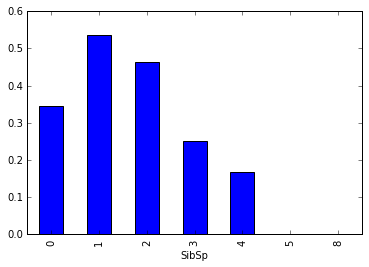

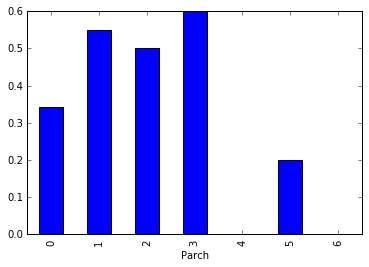

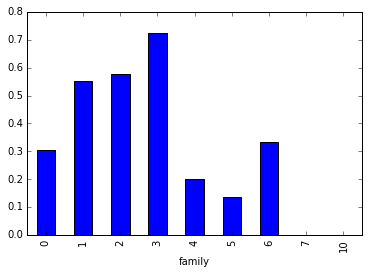

In [5]:
train["family"] = train["SibSp"] + train["Parch"]
for i in ["SibSp", "Parch", "family"]:
    pit = train.pivot_table(index = i, values = "Survived")
    pit.plot.bar()
    plt.show()

Looking at the survival rates of the the combined family members, you can see that few of the 30% passengers with no family members survived, while greater numbers of passengers with family members survived.

In [6]:
def famCheck(df):
    df["isalone"] =0
    df.loc[(df["family"] == 0),"isalone"] = 1
    return df
train = famCheck(train)
holdout["family"] = holdout["SibSp"] + holdout["Parch"]
holdout = famCheck(holdout)

In [7]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis =1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

cols = select_features(train)

Best Columns 
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'family', 'isalone']



In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, inpu):
    all_X = train[inpu]
    all_Y = train["Survived"]
    
    model = [{
        "name":"LogisticRegression",
        "estimator":LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]
    for i in model:
        print(i["name"])
        print("-"*len(i["name"]))
        
        grid = GridSearchCV(i["estimator"],param_grid = i["hyperparameters"],cv=10)
        grid.fit(all_X, all_Y)
        i["best_param"] = grid.best_params_
        i["best_score"] = grid.best_score_
        i["best_model"] = grid.best_estimator_
        
        print("Best score:{}".format(i["best_score"]))
        print("Best parameter:{}".format(i["best_param"]))
    return model
result = select_model(train,cols)

LogisticRegression
------------------
Best score:0.8215488215488216
Best parameter:{'solver': 'lbfgs'}
KNeighborsClassifier
--------------------
Best score:0.7800224466891134
Best parameter:{'p': 1, 'weights': 'uniform', 'algorithm': 'kd_tree', 'n_neighbors': 3}
RandomForestClassifier
----------------------
Best score:0.8406285072951739
Best parameter:{'max_depth': 10, 'min_samples_split': 5, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 9}
